In [1]:
import matplotlib.pyplot as plt
import autograd
import autograd.numpy as np
import autograd.scipy as sp
import autograd.misc.optimizers
import numpy
from tqdm import tqdm

In [2]:
def u1(z, N=1):
    # z is data n x m x 2
    # N is normalizing constant
    exp_factor = 1/2*((np.linalg.norm(z, axis=2) - 2)/0.4)**2 - \
                 np.log(np.exp(-1/2*((z[:,:,0] - 2)/0.6)**2) + np.exp(-1/2*((z[:,:,0] + 2)/0.6)**2))
    return N * np.exp(-exp_factor)

def u2(z, N=1):
    exp_factor = 1/2*((z[:,:,1] - np.sin(2*np.pi*z[:,:,0]/4))/0.4)**2
    return np.exp(-exp_factor)

In [3]:
# Parameters

h = np.tanh

u = u2

q_0_mu = np.array([0,0])
q_0_sigma = 1
D = q_0_mu.shape[0]
num_samples = 1000

num_flows = 10
lambda_flows = np.array([np.array([1., 1., 0., 0., 0.])]*num_flows)

m = 10000
step_size = .01

use_adam = True


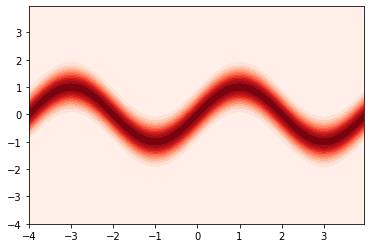

In [4]:
X, Y = numpy.mgrid[-4:4:0.05, -4:4:0.05]
dat = np.dstack((X, Y))
U_z = u(dat)

fig, ax = plt.subplots()
ax.contourf(X, Y, U_z, cmap='Reds', levels=15)
plt.show()

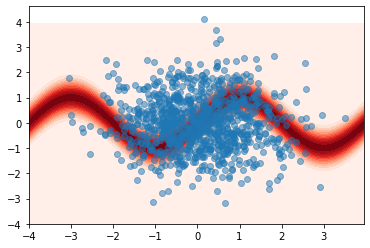

In [5]:
# Samples from initial distribution
samples = np.random.multivariate_normal(q_0_mu, q_0_sigma*np.eye(D), num_samples)

fig, ax = plt.subplots()
ax.contourf(X, Y, U_z, cmap='Reds', levels=15)
ax.scatter(samples[:, 0], samples[:, 1], alpha=.5)
plt.show()

In [6]:
# lambda u, w, b

# Flow multiple times
def flow_samples(lambda_flows, z, h):
    for lambda_flow in lambda_flows:
        z = flow_once(lambda_flow, z, h)
    return z

# Flow once
def flow_once(lambda_flow, z, h):
    D = (lambda_flow.shape[0]-1)//2
    return z + h((z @ lambda_flow[D:2*D].reshape(-1, 1))+lambda_flow[-1]) @ lambda_flow[:D].reshape(1, -1)

# Psi
def psi(lambda_flow, z, h):
    D = (lambda_flow.shape[0]-1)//2
    return (1-h((z @ lambda_flow[D:2*D].reshape(-1, 1))+lambda_flow[-1])**2) * lambda_flow[D:2*D]

In [7]:
# Calculate energy bound
def energy_bound(lambda_flows, z, h, u, beta=1.):
    D = (lambda_flows.shape[1]-1)//2
    initial_exp = np.mean(np.log(sp.stats.norm.pdf(z, loc=q_0_mu, scale=np.sqrt(q_0_sigma))))
    joint_exp = beta*np.mean(np.log(u(flow_samples(lambda_flows, z, h).reshape(-1, 1, 2))))
    flow_exp = 0.
    for lambda_flow in lambda_flows:
        flow_exp += np.mean(np.log(np.abs(1 + np.dot(psi(lambda_flow, z, h), lambda_flow[:D]))))
        z = flow_once(lambda_flow, z, h)
    return initial_exp - joint_exp - flow_exp

In [8]:
def get_joint_exp(lambda_flows, z, h):
    return np.mean(np.log(u(flow_samples(lambda_flows, z, h).reshape(1, -1, 2))))

In [9]:
def get_flow_exp(lambda_flows, z, h):
    D = (lambda_flows.shape[1]-1)//2
    flow_exp = 0
    for lambda_flow in lambda_flows:
        flow_exp += np.mean(np.log(np.abs(1 + np.dot(psi(lambda_flow, z, h), lambda_flow[:D]))))
        z = flow_once(lambda_flow, z, h)
        
    return flow_exp

In [10]:
def get_initial_exp(z):
    return np.mean(np.log(sp.stats.norm.pdf(z, loc=q_0_mu, scale=np.sqrt(q_0_sigma))))

In [11]:
grad_energy_bound = autograd.grad(energy_bound)

In [12]:
def get_beta(i):
    return min(1, 0.01+i/10000)

In [13]:
def callback(x, i, g):
    samples_flowed = flow_samples(x, samples, h)
    
    # Debug
    initial_hist[i] = get_initial_exp(samples)
    energy_hist[i] = energy_bound(x, samples, h, u)
    joint_hist[i] = get_joint_exp(x, samples, h)
    flow_hist[i] = get_flow_exp(x, samples, h)
    lambda_hist[i] = lambda_flows
    
    # Plot
    if i % 1000 == 0:
        fig, ax = plt.subplots()
        ax.contourf(X, Y, U_z, cmap='Reds', levels=15)
        ax.scatter(samples_flowed[:, 0], samples_flowed[:, 1], alpha=.5)
        plt.show()

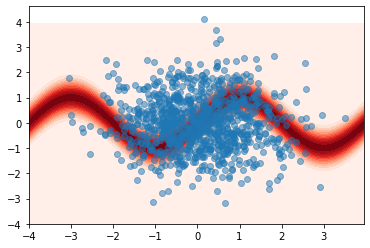

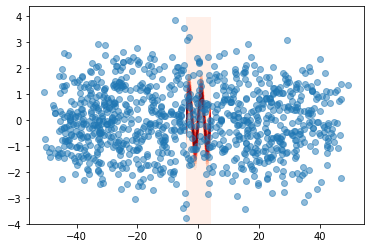

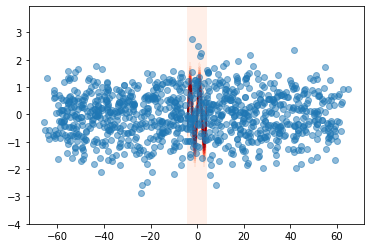

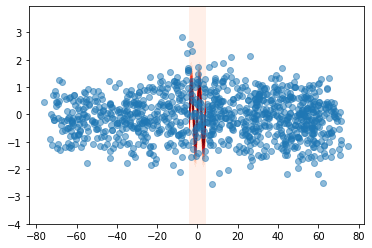

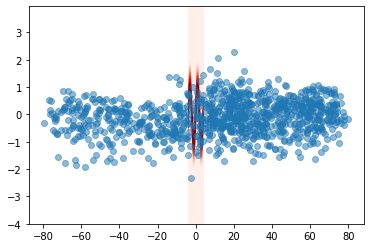

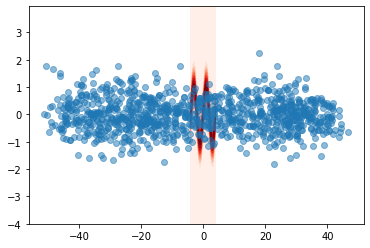

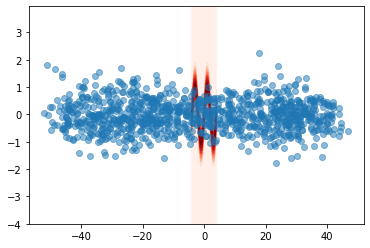

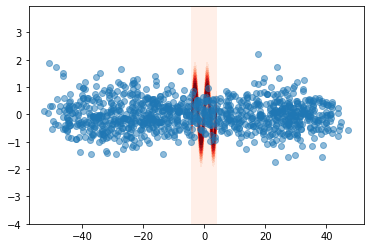

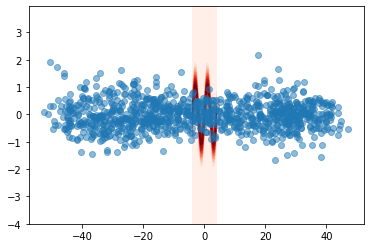

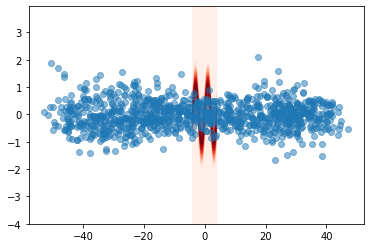

In [14]:
initial_hist = np.empty(m)
energy_hist = np.empty(m)
joint_hist = np.empty(m)
flow_hist = np.empty(m)
lambda_hist = np.empty((m, *lambda_flows.shape))

if use_adam:
    grad_energy_bound_lambda = lambda params, i : grad_energy_bound(params, samples, h, u, get_beta(i))
    lambda_flows = autograd.misc.optimizers.adam(grad_energy_bound_lambda, lambda_flows,
                                                 callback=callback, num_iters=m, step_size=step_size)
else:
    for i in tqdm(range(m)):
        gradient = grad_energy_bound(lambda_flows, samples, h, get_beta(i))
        lambda_flows -= step_size*gradient

        callback(lambda_flows, i, gradient)

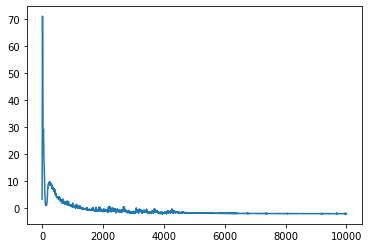

In [15]:
plt.plot(energy_hist)

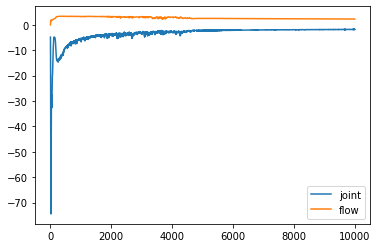

In [16]:
plt.plot(joint_hist, label='joint')
plt.plot(flow_hist, label='flow')
plt.legend()
# plt.ylim((-4, 1))